In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [7]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns
Date,,,,,,,,,
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,-0.296251


# Data Preparation

### Returns

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Returns'] = yen_futures.Settle.pct_change() * 100
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [27]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures.Returns.shift().dropna()
lagged_returns = yen_futures.dropna()
lagged_returns

<ipython-input-27-0194dda6eca4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yen_futures['Lagged_Return'] = yen_futures.Returns.shift().dropna()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns,Lagged_Return
Date,,,,,,,,,,
2014-02-28,9787.0,9848.0,9776.0,9825.0,27.0,9825.0,169374.0,200184.0,0.275566,0.389344
2014-03-03,9840.0,9882.0,9840.0,9857.0,34.0,9859.0,149003.0,197621.0,0.346056,0.275566
2014-03-04,9859.0,9862.0,9776.0,9785.0,79.0,9780.0,137014.0,196097.0,-0.801298,0.346056
2014-03-06,9771.0,9773.0,9692.0,9705.0,69.0,9705.0,172188.0,199340.0,-0.766871,-0.801298
2014-03-07,9702.0,9724.0,9637.0,9681.0,24.0,9681.0,156252.0,201541.0,-0.247295,-0.766871
...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458


### Train Test Split

In [43]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = lagged_returns['2018':'2019']
test = lagged_returns['2018']

<ipython-input-43-c0cf19f6d4d4>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = lagged_returns['2018']


In [44]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame().dropna()
y_train = train["Returns"]
X_test = test["Lagged_Return"].to_frame().dropna()
y_test = test["Returns"]

In [46]:
X_train.head()

,Lagged_Return
Date,
2018-01-02,0.224871
2018-01-03,0.297285
2018-01-04,-0.240479
2018-01-05,-0.213028
2018-01-08,-0.353933


# Linear Regression Model

In [48]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [53]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [54]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results['Predicted Returns'] = predictions

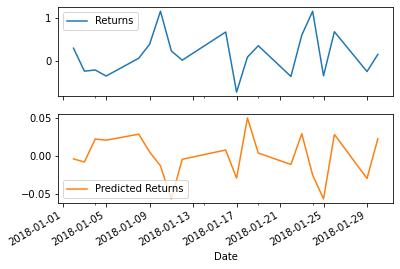

In [56]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True);

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [63]:
from sklearn.metrics import mean_squared_error


# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Returns"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f'Out-of-sample Root Mean Square Error (RMSE) {rmse}')

Out-of-sample Root Mean Square Error (RMSE) 0.4284535930348139


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [70]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results['In-sample Prediction'] = model.predict(X_train)


# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_results = mean_squared_error(in_sample_results['Returns'],
                                      in_sample_results['In-sample Prediction'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
print(f'In-Sample Root mEan Squarred Error (RMSE): {in_sample_results}')

In-Sample Root mEan Squarred Error (RMSE): 0.17187721623700317


# Conclusions

YOUR CONCLUSIONS HERE!

##
The out-of-sample RMSE (.42) is lower than the in-sample RMSE (.60). RMSE is typically lower for training data, but is higher in this case. This means the model made better predictions on data it has never seen before (the test set) than the actual training set. Therefore, I would not trust these predictions, and would instead develop a new model.